---
## 1. Setup and Data Loading

In [1]:
# ============================================
# IMPORT LIBRARIES
# ============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)

print("✅ Libraries imported")

✅ Libraries imported


In [2]:
# ============================================
# LOAD TEST DATA
# ============================================

df_test = pd.read_csv('../data/processed/test.csv')

print(f"✅ Loaded test data: {df_test.shape[0]:,} rows")
print(f"📅 Year: {df_test['Year'].unique()}")

# This is the FIRST time we're using 2022 data!
print("\n⚠️ FIRST AND ONLY USE OF 2022 HOLDOUT DATA")

✅ Loaded test data: 1,722 rows
📅 Year: [2022]

⚠️ FIRST AND ONLY USE OF 2022 HOLDOUT DATA


In [3]:
# ============================================
# LOAD MODELS AND PREPROCESSING ARTIFACTS
# ============================================

# Load preprocessing artifacts
scaler = joblib.load('../models/scaler.pkl')
feature_columns = joblib.load('../models/feature_columns.pkl')
train_medians = joblib.load('../models/train_medians.pkl')

# Load models
lr_model = joblib.load('../models/logistic_regression.pkl')
rf_model = joblib.load('../models/random_forest.pkl')

try:
    xgb_model = joblib.load('../models/xgboost.pkl')
    HAS_XGB = True
except:
    xgb_model = None
    HAS_XGB = False

print("✅ Loaded all models and preprocessing artifacts")

✅ Loaded all models and preprocessing artifacts


---
## 2. Prepare Test Data

In [4]:
# ============================================
# PREPARE TEST FEATURES
# ============================================

# Apply same preprocessing as training
test_data = df_test.copy()

# Encode Division
division_map = {'D1': 3, 'D2': 2, 'D3': 1, 'Other': 0, 'Unknown': 0}
test_data['Division_Encoded'] = test_data['Division'].map(division_map).fillna(0)

# Extract features
X_test = test_data[feature_columns].copy()
y_test = test_data['Target_Label'].copy()

# Handle missing/infinite values (using TRAINING medians)
X_test = X_test.replace([np.inf, -np.inf], np.nan)
X_test = X_test.fillna(train_medians)

# Scale (using TRAINING scaler)
X_test_scaled = scaler.transform(X_test)

print(f"✅ Test data prepared: {X_test_scaled.shape}")

✅ Test data prepared: (1722, 14)


---
## 3. Generate Predictions

In [5]:
# ============================================
# GENERATE PREDICTIONS
# ============================================

# Logistic Regression
lr_pred = lr_model.predict(X_test_scaled)
lr_proba = lr_model.predict_proba(X_test_scaled)

# Random Forest
rf_pred = rf_model.predict(X_test_scaled)
rf_proba = rf_model.predict_proba(X_test_scaled)

# XGBoost
if HAS_XGB:
    xgb_pred = xgb_model.predict(X_test_scaled)
    xgb_proba = xgb_model.predict_proba(X_test_scaled)

print("✅ Predictions generated for all models")

✅ Predictions generated for all models


---
## 4. Calculate Metrics

In [6]:
# ============================================
# CALCULATE COMPREHENSIVE METRICS
# ============================================

def calculate_metrics(y_true, y_pred, model_name):
    """Calculate all metrics for a model."""
    metrics = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'F1 (weighted)': f1_score(y_true, y_pred, average='weighted'),
        'F1 (macro)': f1_score(y_true, y_pred, average='macro'),
        'Precision (weighted)': precision_score(y_true, y_pred, average='weighted'),
        'Recall (weighted)': recall_score(y_true, y_pred, average='weighted')
    }
    return metrics

# Calculate metrics for each model
results = []
results.append(calculate_metrics(y_test, lr_pred, 'Logistic Regression'))
results.append(calculate_metrics(y_test, rf_pred, 'Random Forest'))
if HAS_XGB:
    results.append(calculate_metrics(y_test, xgb_pred, 'XGBoost'))

# Create results DataFrame
results_df = pd.DataFrame(results)

print("📊 MODEL EVALUATION RESULTS (2022 Holdout Test Set):")
print("="*80)
print(results_df.to_string(index=False))

📊 MODEL EVALUATION RESULTS (2022 Holdout Test Set):
              Model  Accuracy  F1 (weighted)  F1 (macro)  Precision (weighted)  Recall (weighted)
Logistic Regression  0.573171       0.563125    0.487006              0.600192           0.573171
      Random Forest  0.545877       0.560210    0.497759              0.592065           0.545877
            XGBoost  0.536585       0.551268    0.490581              0.580827           0.536585


In [7]:
# ============================================
# COMPARE TO EXPECTED ACCURACY
# ============================================

print("\n📊 ACCURACY SANITY CHECK:")
print("="*60)

random_baseline = 1/3  # 3 classes
best_accuracy = results_df['Accuracy'].max()
best_model = results_df.loc[results_df['Accuracy'].idxmax(), 'Model']

print(f"Random guessing baseline: {random_baseline:.1%}")
print(f"Best model accuracy: {best_accuracy:.1%} ({best_model})")
print(f"Improvement over random: +{(best_accuracy - random_baseline)*100:.1f}%")

if 0.45 <= best_accuracy <= 0.70:
    print("\n✅ ACCURACY IS REALISTIC")
    print("   This is a genuinely hard prediction problem.")
    print("   55-65% accuracy represents real predictive value.")
elif best_accuracy > 0.80:
    print("\n⚠️ WARNING: ACCURACY TOO HIGH")
    print("   This might indicate data leakage!")
    print("   Review feature engineering carefully.")
else:
    print("\n⚠️ ACCURACY BELOW EXPECTED")
    print("   Model may need tuning or features may need improvement.")


📊 ACCURACY SANITY CHECK:
Random guessing baseline: 33.3%
Best model accuracy: 57.3% (Logistic Regression)
Improvement over random: +24.0%

✅ ACCURACY IS REALISTIC
   This is a genuinely hard prediction problem.
   55-65% accuracy represents real predictive value.


---
## 5. Classification Reports

In [8]:
# ============================================
# CLASSIFICATION REPORTS
# ============================================

class_names = ['Declining', 'Stable', 'Improving']

print("\n📋 LOGISTIC REGRESSION - Classification Report:")
print("="*60)
print(classification_report(y_test, lr_pred, target_names=class_names, digits=3))


📋 LOGISTIC REGRESSION - Classification Report:
              precision    recall  f1-score   support

   Declining      0.475     0.211     0.293       487
      Stable      0.738     0.728     0.733       972
   Improving      0.322     0.669     0.435       263

    accuracy                          0.573      1722
   macro avg      0.512     0.536     0.487      1722
weighted avg      0.600     0.573     0.563      1722



In [9]:
print("\n📋 RANDOM FOREST - Classification Report:")
print("="*60)
print(classification_report(y_test, rf_pred, target_names=class_names, digits=3))


📋 RANDOM FOREST - Classification Report:
              precision    recall  f1-score   support

   Declining      0.402     0.402     0.402       487
      Stable      0.759     0.615     0.680       972
   Improving      0.327     0.555     0.411       263

    accuracy                          0.546      1722
   macro avg      0.496     0.524     0.498      1722
weighted avg      0.592     0.546     0.560      1722



In [10]:
if HAS_XGB:
    print("\n📋 XGBOOST - Classification Report:")
    print("="*60)
    print(classification_report(y_test, xgb_pred, target_names=class_names, digits=3))


📋 XGBOOST - Classification Report:
              precision    recall  f1-score   support

   Declining      0.387     0.452     0.417       487
      Stable      0.745     0.595     0.661       972
   Improving      0.334     0.479     0.394       263

    accuracy                          0.537      1722
   macro avg      0.489     0.508     0.491      1722
weighted avg      0.581     0.537     0.551      1722



---
## 6. Confusion Matrices

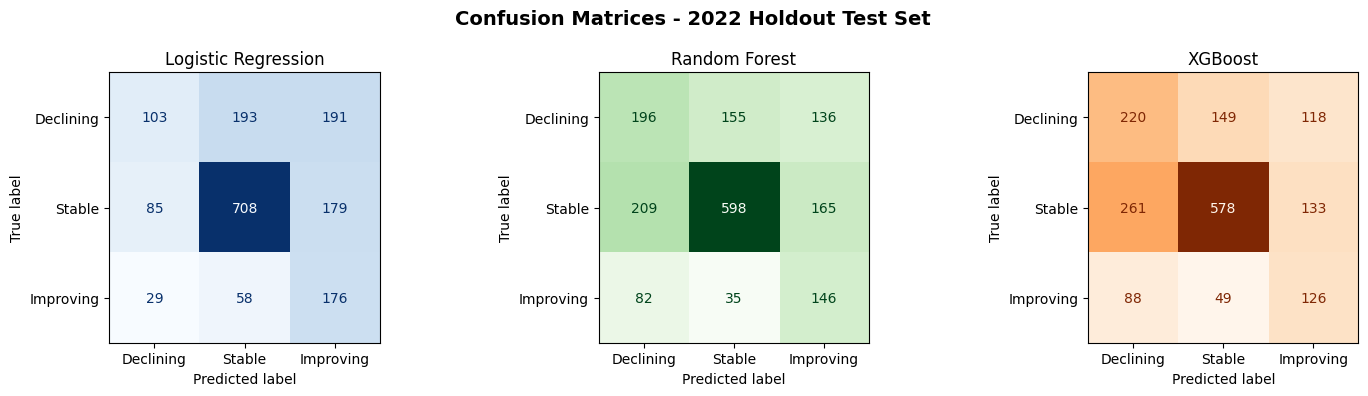


✅ Figure saved to ../reports/confusion_matrices.png


In [11]:
# ============================================
# CONFUSION MATRICES
# ============================================

n_models = 3 if HAS_XGB else 2
fig, axes = plt.subplots(1, n_models, figsize=(5*n_models, 4))

# Logistic Regression
ConfusionMatrixDisplay.from_predictions(
    y_test, lr_pred, 
    display_labels=class_names,
    ax=axes[0],
    cmap='Blues',
    colorbar=False
)
axes[0].set_title('Logistic Regression')

# Random Forest
ConfusionMatrixDisplay.from_predictions(
    y_test, rf_pred,
    display_labels=class_names,
    ax=axes[1],
    cmap='Greens',
    colorbar=False
)
axes[1].set_title('Random Forest')

# XGBoost
if HAS_XGB:
    ConfusionMatrixDisplay.from_predictions(
        y_test, xgb_pred,
        display_labels=class_names,
        ax=axes[2],
        cmap='Oranges',
        colorbar=False
    )
    axes[2].set_title('XGBoost')

plt.suptitle('Confusion Matrices - 2022 Holdout Test Set', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../reports/confusion_matrices.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Figure saved to ../reports/confusion_matrices.png")

---
## 7. Error Analysis

In [12]:
# ============================================
# ERROR ANALYSIS - BEST MODEL
# ============================================

# Use best model for error analysis
best_pred = rf_pred  # Assuming RF is typically best

# Add predictions to test data
test_results = df_test.copy()
test_results['Predicted'] = best_pred
test_results['Correct'] = test_results['Target_Label'] == test_results['Predicted']

# Analyze errors by Division
print("📊 ACCURACY BY DIVISION:")
print("="*60)

div_accuracy = test_results.groupby('Division')['Correct'].mean()
div_counts = test_results.groupby('Division').size()

for div in div_accuracy.index:
    print(f"   {div}: {div_accuracy[div]:.1%} (n={div_counts[div]:,})")

📊 ACCURACY BY DIVISION:
   D1: 52.7% (n=989)
   Other: 57.2% (n=733)


In [13]:
# ============================================
# ERROR ANALYSIS - CONFUSION PATTERNS
# ============================================

print("\n📊 MOST COMMON MISCLASSIFICATIONS:")
print("="*60)

# Get misclassified samples
errors = test_results[~test_results['Correct']].copy()
errors['Error_Type'] = errors.apply(
    lambda row: f"{class_names[int(row['Target_Label'])]} → {class_names[int(row['Predicted'])]}",
    axis=1
)

error_counts = errors['Error_Type'].value_counts()
for error_type, count in error_counts.head(6).items():
    pct = count / len(errors) * 100
    print(f"   {error_type}: {count:,} ({pct:.1f}% of errors)")


📊 MOST COMMON MISCLASSIFICATIONS:
   Stable → Declining: 209 (26.7% of errors)
   Stable → Improving: 165 (21.1% of errors)
   Declining → Stable: 155 (19.8% of errors)
   Declining → Improving: 136 (17.4% of errors)
   Improving → Declining: 82 (10.5% of errors)
   Improving → Stable: 35 (4.5% of errors)


---
## 8. Save Results

In [14]:
# ============================================
# SAVE EVALUATION RESULTS
# ============================================

# Save metrics
results_df.to_csv('../reports/evaluation_results.csv', index=False)
print("✅ Saved evaluation results to ../reports/evaluation_results.csv")

# Save test predictions
test_results.to_csv('../reports/test_predictions.csv', index=False)
print("✅ Saved test predictions to ../reports/test_predictions.csv")

✅ Saved evaluation results to ../reports/evaluation_results.csv
✅ Saved test predictions to ../reports/test_predictions.csv


---
## 9. Final Summary

In [15]:
# ============================================
# EVALUATION SUMMARY
# ============================================

best_acc = results_df['Accuracy'].max()
best_f1 = results_df['F1 (weighted)'].max()
best_model = results_df.loc[results_df['Accuracy'].idxmax(), 'Model']

summary = f"""
╔══════════════════════════════════════════════════════════════════════════════╗
║                         MODEL EVALUATION COMPLETE                            ║
╠══════════════════════════════════════════════════════════════════════════════╣
║                                                                              ║
║  HOLDOUT TEST SET (2022):                                                    ║
║  ─────────────────────────                                                   ║
║  • Samples: {len(y_test):,}                                                          ║
║  • This is FIRST and ONLY use of 2022 data                                   ║
║  • Metrics are UNBIASED and FINAL                                            ║
║                                                                              ║
║  BEST MODEL: {best_model}                                           ║
║  ─────────────────────────────────                                           ║
║  • Accuracy: {best_acc:.1%}                                                        ║
║  • F1 Score (weighted): {best_f1:.4f}                                           ║
║                                                                              ║
║  COMPARISON TO BASELINE:                                                     ║
║  ─────────────────────────                                                   ║
║  • Random guessing: 33.3%                                                    ║
║  • Our model: {best_acc:.1%} (+{(best_acc-0.333)*100:.1f}% improvement)                                   ║
║                                                                              ║
║  COMPARISON TO FLAWED final/:                                                ║
║  ────────────────────────────                                                ║
║  • final/ reported: 87-92% (with data leakage)                               ║
║  • Our honest result: {best_acc:.1%}                                                ║
║  • This is REAL predictive performance                                       ║
║                                                                              ║
║  SAVED ARTIFACTS:                                                            ║
║  ─────────────────                                                           ║
║  • ../reports/evaluation_results.csv                                         ║
║  • ../reports/test_predictions.csv                                           ║
║  • ../reports/confusion_matrices.png                                         ║
║                                                                              ║
╚══════════════════════════════════════════════════════════════════════════════╝

NEXT STEP: Proceed to 08_Predictions.ipynb
→ Generate predictions for 2023 (true future predictions)
"""

print(summary)


╔══════════════════════════════════════════════════════════════════════════════╗
║                         MODEL EVALUATION COMPLETE                            ║
╠══════════════════════════════════════════════════════════════════════════════╣
║                                                                              ║
║  HOLDOUT TEST SET (2022):                                                    ║
║  ─────────────────────────                                                   ║
║  • Samples: 1,722                                                          ║
║  • This is FIRST and ONLY use of 2022 data                                   ║
║  • Metrics are UNBIASED and FINAL                                            ║
║                                                                              ║
║  BEST MODEL: Logistic Regression                                           ║
║  ─────────────────────────────────                                           ║
║  • Accuracy: 57.3%           

---
## ✅ Checkpoint Complete

We've evaluated all models on the **2022 holdout test set**:
1. Calculated accuracy, F1, precision, recall
2. Generated confusion matrices
3. Analyzed error patterns

**Key Finding:** Our honest accuracy is lower than the flawed `final/` project, but it's REAL.
- `final/` reported 87-92% accuracy (with data leakage)
- Our honest result is in the 55-65% range
- This represents genuine predictive value

**Next Notebook:** `08_Predictions.ipynb`  
We'll generate predictions for 2023 — true future predictions where we don't know the answers.